In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from pathlib import Path
import random

In [4]:
weights_path = '../input/yolo-coco-data/yolov3.weights'
configuration_path = '../input/yolo-coco-data/yolov3.cfg'
labels_path = '../input/yolo-coco-data/coco.names'

In [5]:
labels = open(labels_path).read().strip().split('\n')
print (labels)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [6]:

network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)
layers_names_all = network.getLayerNames()
layers_names_output = [layers_names_all[i - 1] for i in network.getUnconnectedOutLayers()]
print(layers_names_output)
probability_minimum = 0.5
threshold = 0.3

['yolo_82', 'yolo_94', 'yolo_106']


In [7]:

def yolo_detection(image_path):
    image = cv2.imread(str(image_path))
    h, w = image.shape[:2]

    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    network.setInput(blob)
    output_from_network = network.forward(layers_names_output)

    bounding_boxes = []
    confidences = []
    class_numbers = []

    for result in output_from_network:
        for detection in result:
            scores = detection[5:]
            class_current = np.argmax(scores)
            confidence_current = scores[class_current]

            if confidence_current > probability_minimum:
                box_current = detection[0:4] * np.array([w, h, w, h])
                x_center, y_center, box_width, box_height = box_current.astype('int')
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))

                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)

    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

    return image, bounding_boxes, confidences, class_numbers, results

In [8]:
def draw_bounding_boxes(image, bounding_boxes, confidences, class_numbers, results):
    if len(results) > 0:
        for i in results.flatten():
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

            colour_box_current = [int(j) for j in np.random.randint(0, 255, size=3)]

            cv2.rectangle(image, (x_min, y_min), (x_min + box_width, y_min + box_height),
                          colour_box_current, 2)

            text_box_current = f'{labels[int(class_numbers[i])]}: {confidences[i]:.4f}'

            cv2.putText(image, text_box_current, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, colour_box_current, 2)

    return image

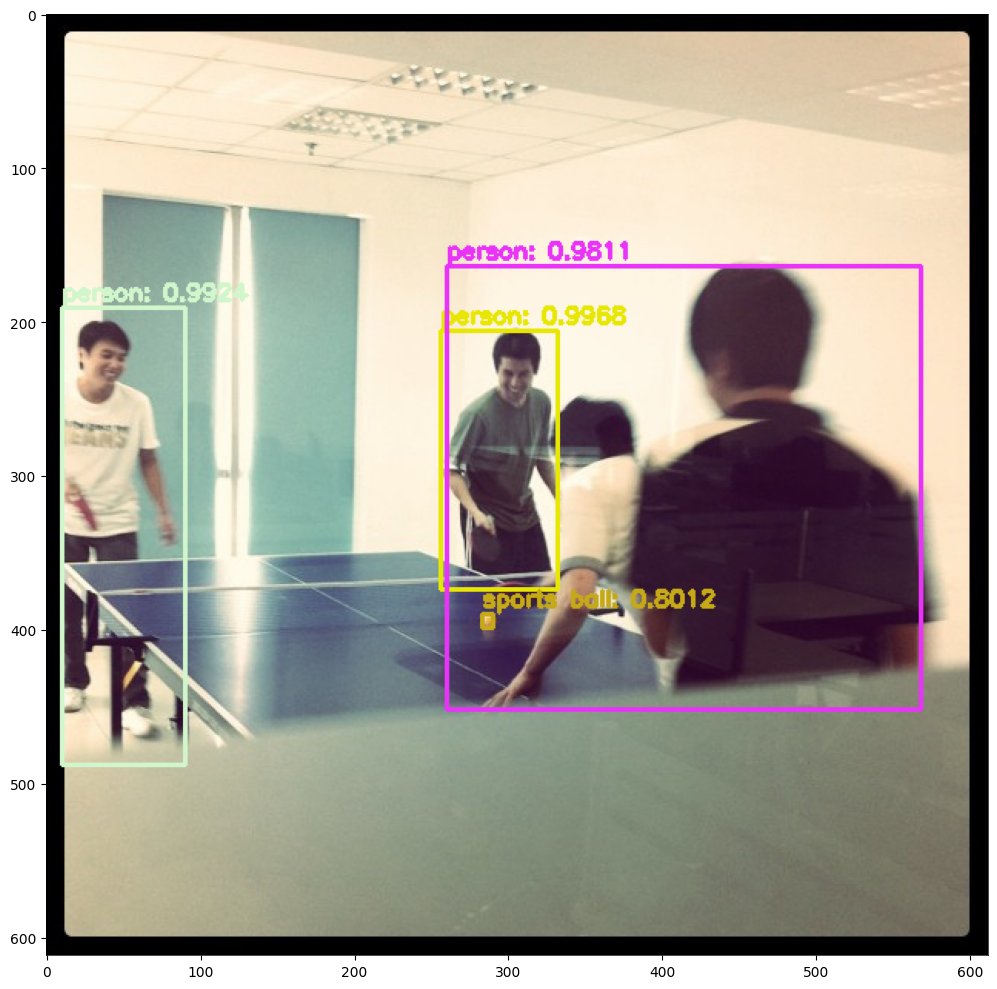

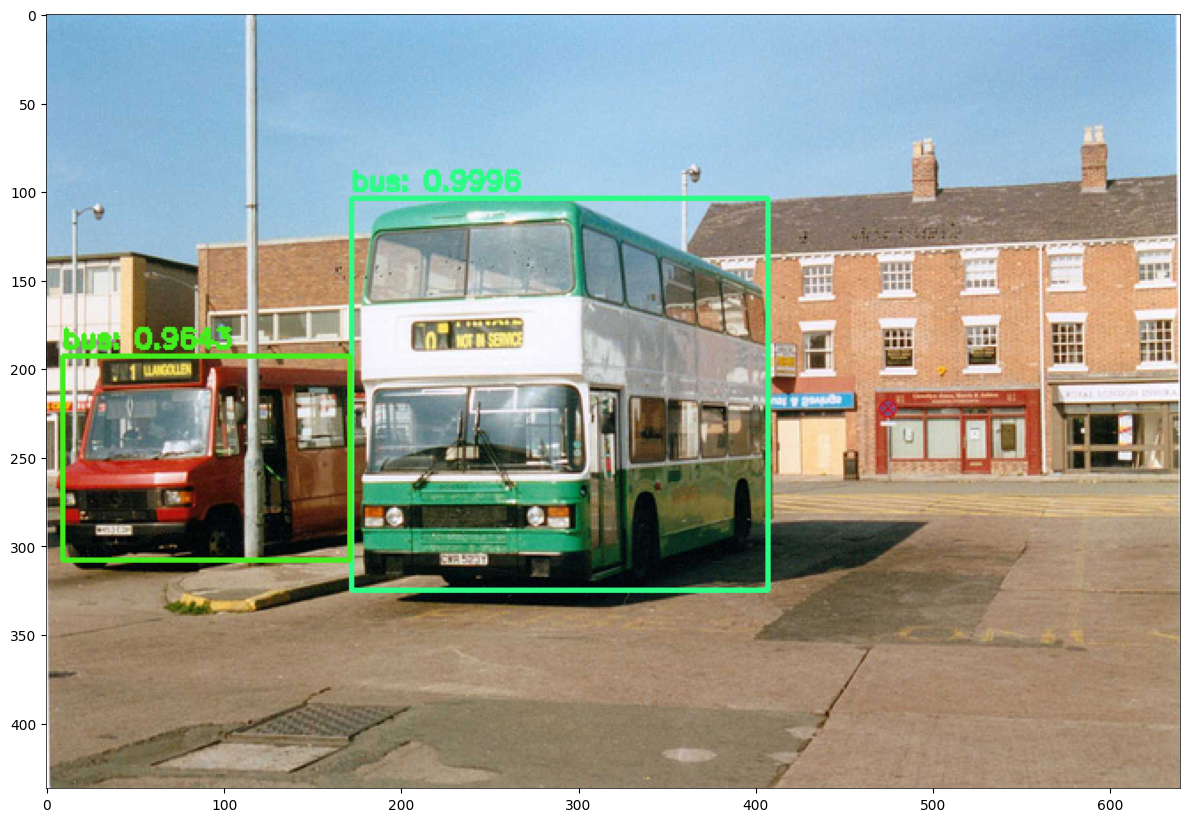

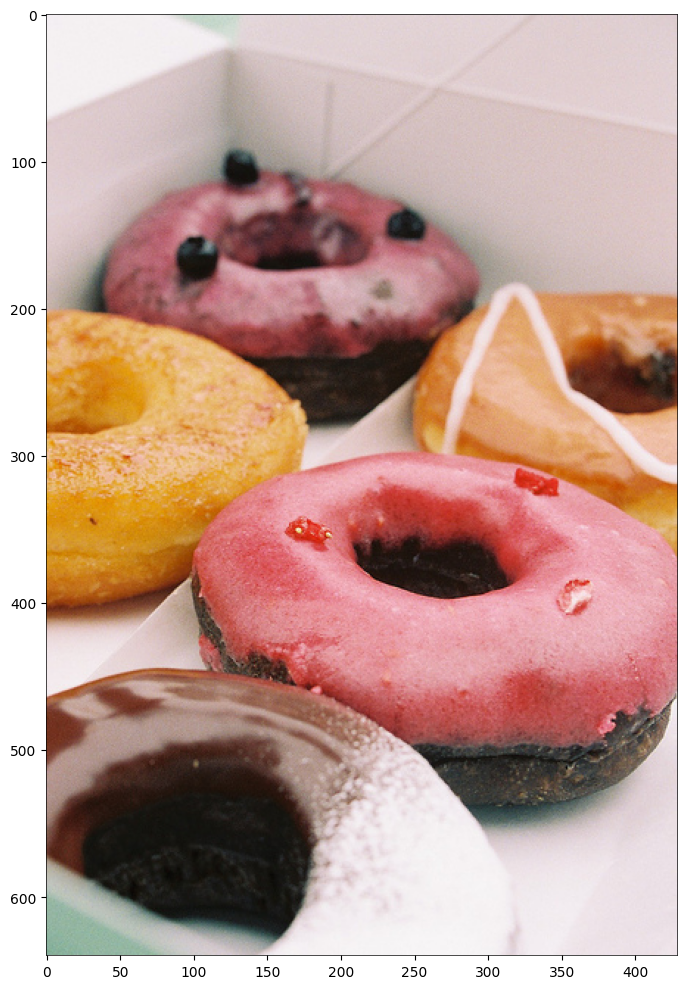

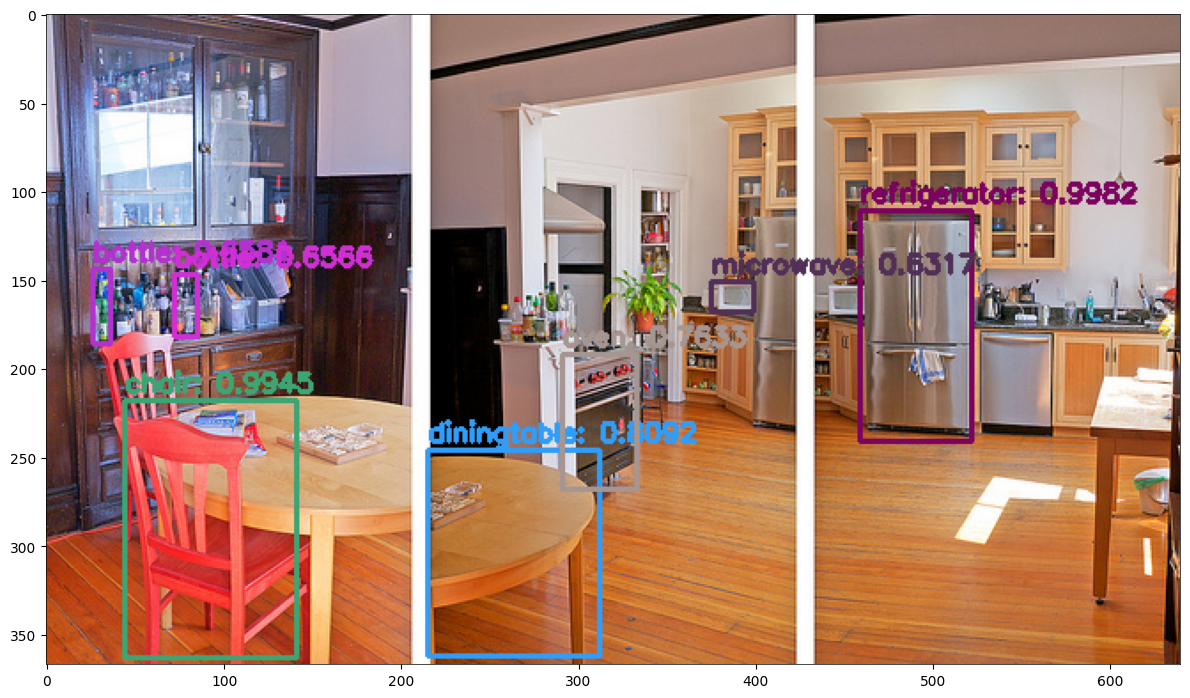

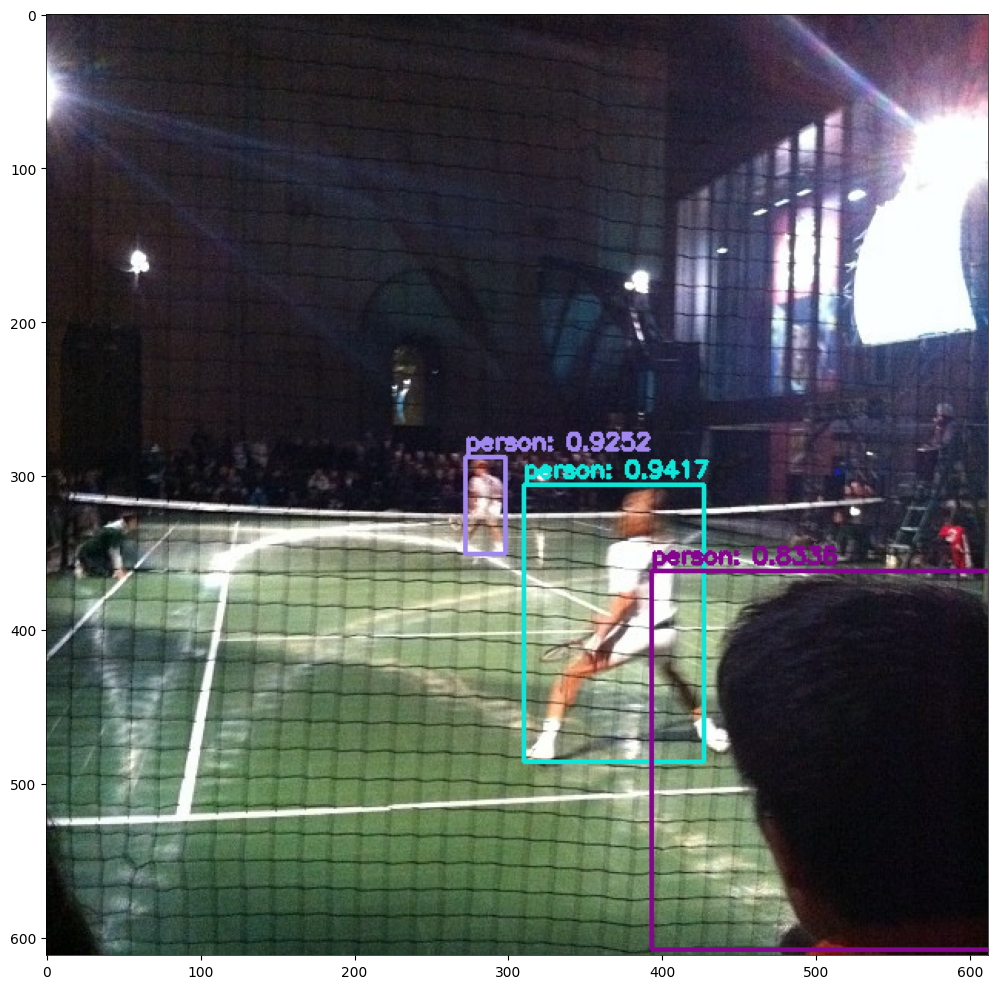

In [10]:
image_path = Path("/kaggle/input/coco-2017-dataset/coco2017/test2017")
image_files = list(image_path.glob("*.jpg")) + list(image_path.glob("*.jpeg"))

# Randomly select 5 images
selected_images = random.sample(image_files, min(5, len(image_files)))

for i, image_file in enumerate(selected_images, 1):
    image, bounding_boxes, confidences, class_numbers, results = yolo_detection(image_file)
    image_with_boxes = draw_bounding_boxes(image, bounding_boxes, confidences, class_numbers, results)
    plt.figure(figsize=(12, 10))
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['right'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)
    plt.gca().spines['top'].set_linewidth(0.5)
    plt.gca().spines['right'].set_linewidth(0.5)
    plt.gca().spines['bottom'].set_linewidth(0.5)
    plt.gca().spines['left'].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()

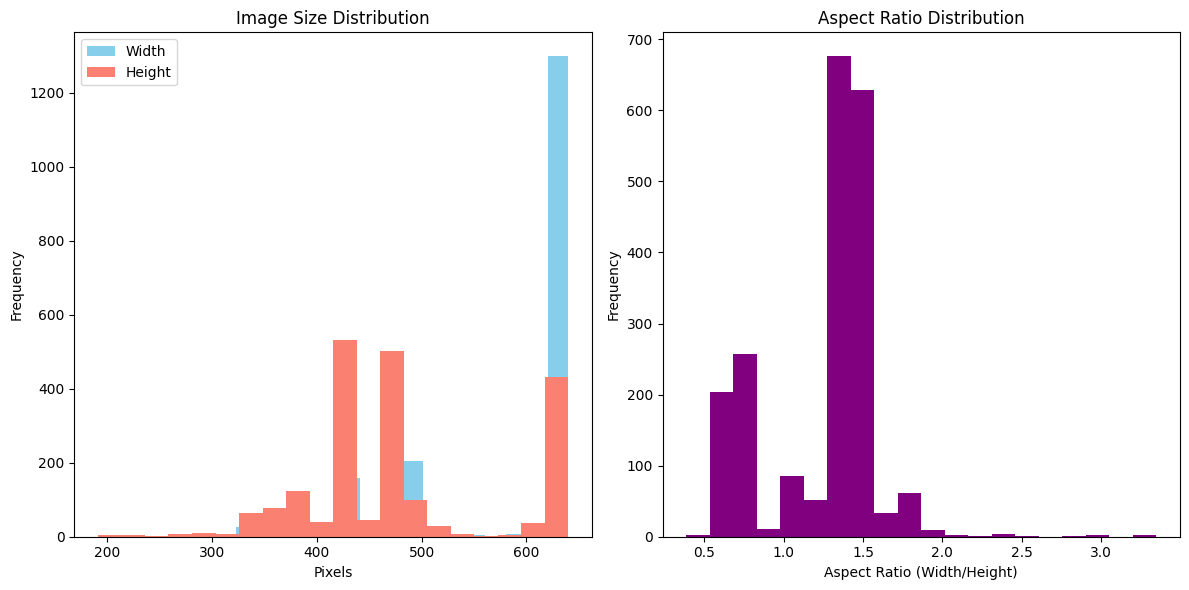

In [11]:
from concurrent.futures import ThreadPoolExecutor
import cv2
def get_image_size_and_ratio(image_file):
    image = cv2.imread(str(image_file))
    if image is not None:
        height, width, _ = image.shape
        return (width, height, width / height)
    return None

sample_size = int(0.05 * len(image_files))
sampled_image_files = random.sample(image_files, sample_size)
image_sizes = []
aspect_ratios = []

with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(executor.map(get_image_size_and_ratio, sampled_image_files))
results = [res for res in results if res is not None]

image_sizes = [(width, height) for width, height, _ in results]
aspect_ratios = [ratio for _, _, ratio in results]

widths, heights = zip(*image_sizes)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color='skyblue', label='Width')
plt.hist(heights, bins=20, color='salmon', label='Height')
plt.title('Image Size Distribution')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(aspect_ratios, bins=20, color='purple')
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


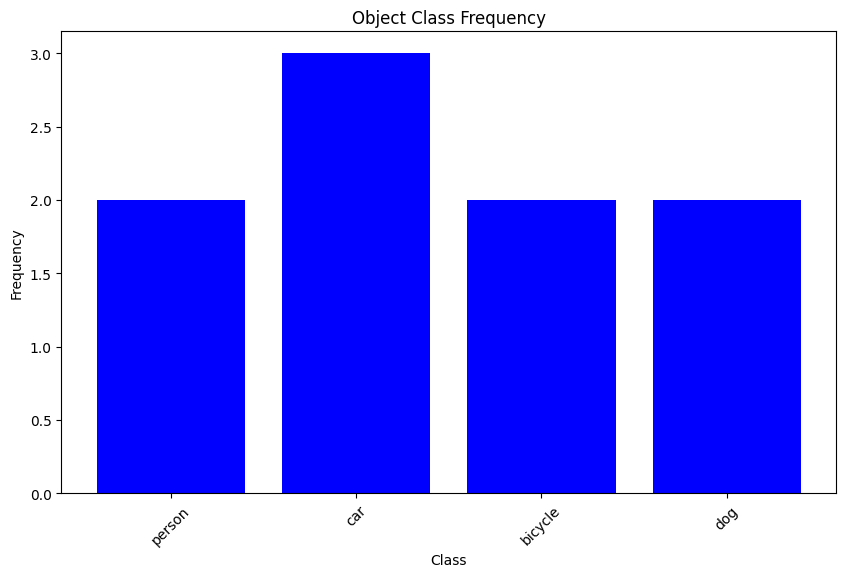

In [12]:
from collections import Counter
import matplotlib.pyplot as plt
detected_classes = ['person', 'car', 'bicycle', 'person', 'car', 'dog', 'bicycle', 'dog', 'car']
class_counts = Counter(detected_classes)
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.title('Object Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
